# Importing all the required libraries to run the models

In [ ]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import save_model
from tensorflow.keras import regularizers
from keras.losses import binary_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint


# Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzipping the dataset for quick retrieval

In [ ]:
!unzip '/content/drive/MyDrive/project_2_dataset.zip'

Archive:  /content/drive/MyDrive/project_2_dataset.zip
  inflating: train/A-D-08DIP-06B-SM.png  
  inflating: train/A-D-08DIP-06F-SM.png  
  inflating: train/A-D-08DIP-07B-SM.png  
  inflating: train/A-D-08DIP-07F-SM.png  
  inflating: train/A-D-08DIP-08B-SM.png  
  inflating: train/A-D-08DIP-08F-SM.png  
  inflating: train/A-D-08DIP-09B-SM.png  
  inflating: train/A-D-08DIP-09F-SM.png  
  inflating: train/A-D-08DIP-10B-SM.png  
  inflating: train/A-D-08DIP-10F-SM.png  
  inflating: train/A-D-16SOIC-06B-D.PNG  
  inflating: train/A-D-64QFP-17F-SM.png  
  inflating: train/A-D-64QFP-18B-SM.png  
  inflating: train/A-D-64QFP-18F-SM.png  
  inflating: train/A-D-64QFP-24B-D.png  
  inflating: train/A-D-64QFP-24F-D.png  
  inflating: train/A-D-64QFP-25B-D.png  
  inflating: train/A-D-64QFP-25F-D.png  
  inflating: train/A-D-64QFP-26B-D.png  
  inflating: train/A-D-64QFP-26F-D.png  
  inflating: train/A-D-64QFP-27B-D.png  
  inflating: train/A-D-64QFP-27F-D.png  
  inflating: train/A-D-64QFP-

# Reading the images and preprocessing before storing into Numpy

In [ ]:
dataset = []
labels = []
genuine = 0
fake = 0
for ic in os.listdir('train'):
    file_path = os.path.join('train', ic)
    circuit = Image.open(file_path)
    resized_circuit = circuit.resize((640,480), Image.LANCZOS)
    circuit_placeholder = Image.new("RGB", (640,480))
    circuit_placeholder.paste(resized_circuit, ((640 - resized_circuit.size[0]) // 2, (480 - resized_circuit.size[1]) // 2))
    circuit_data = np.array(circuit_placeholder)
    circuit_data = circuit_data / 255.0
    if ic[0] == 'A':
        target = 1
        genuine += 1
    elif ic[0] == 'C':
        target = 0
        fake += 1
    dataset.append(circuit_data)
    labels.append(target)
resized_image_data = np.stack(dataset)
target_data = np.stack(labels)

# Fetching Trends from the Dataset

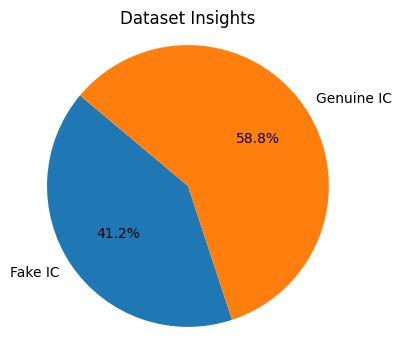

In [ ]:
counts = np.bincount(labels)

plt.figure(figsize=(4, 4))
plt.pie(counts, labels=['Fake IC', 'Genuine IC'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Dataset Insights')
plt.show()

# Splitting the dataset into test and train batches in the ratio 2:8

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(resized_image_data, target_data, test_size=0.2, stratify=target_data, random_state=42)



print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (68, 480, 640, 3) (68,)
Testing data shape: (17, 480, 640, 3) (17,)


# Performing Data Augmentation

In [ ]:
# Data augmentation
def image_augment(X_train, y_train):
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        vertical_flip=True,
        horizontal_flip=True)
    train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
    x_train_augmented = []
    y_train_augmented = []
    for i in range(len(train_generator)):
        batch_images, batch_labels = train_generator[i]
        x_train_augmented.extend(batch_images)
        y_train_augmented.extend(batch_labels)

    x_train_augmented = np.array(x_train_augmented)
    y_train_augmented = np.array(y_train_augmented)
    return x_train_augmented, y_train_augmented

In [ ]:
num_augmented_images = 10

augmented_images = []
augmented_labels = []

for i, image in enumerate(X_train):
    for j in range(num_augmented_images):
        angle = np.random.randint(-20, 20)
        scale = np.random.uniform(0.9, 1.1)
        tx = np.random.randint(-5, 5)
        ty = np.random.randint(-5, 5)

        rows, cols, _ = image.shape
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, scale)
        M[:, 2] += (tx, ty)
        augmented_image = cv2.warpAffine(image, M, (cols, rows))

        augmented_images.append(augmented_image)

        augmented_labels.append(y_train[i])

augmented_images_array = np.array(augmented_images)
augmented_labels_array = np.array(augmented_labels)

X_train = np.concatenate((X_train, augmented_images_array), axis=0)
y_train = np.concatenate((y_train, augmented_labels_array), axis=0)

print("Shape of X_train_augmented:", X_train.shape)
print("Shape of y_train_augmented:", y_train.shape)


Shape of X_train_augmented: (748, 480, 640, 3)
Shape of y_train_augmented: (748,)


# Viewing Sample images

Image before augmentation


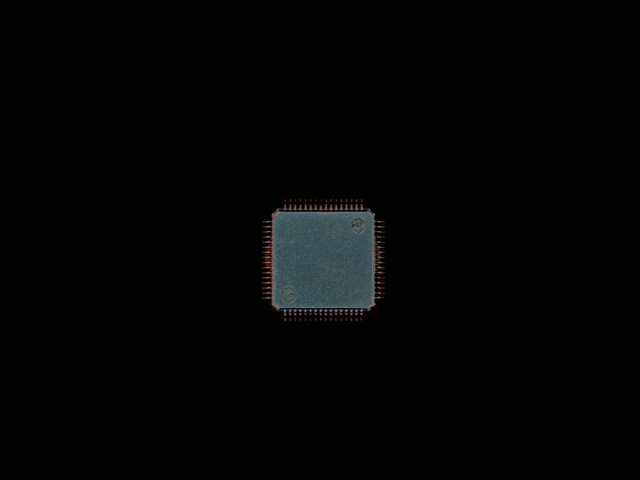

Image after augmentation


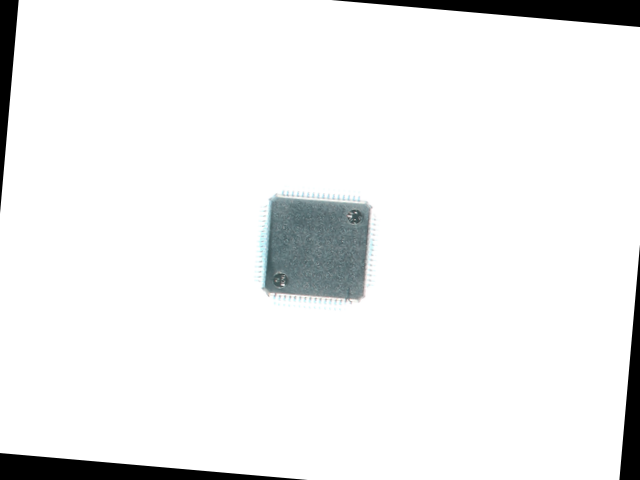

In [ ]:
random_number = random.randint(0,67)
print("Image before augmentation")
s_random_number = random_number + 68
image_array_uint8 = (X_train[random_number] * 255).astype(np.uint8)

image = Image.fromarray(image_array_uint8)
display(image)
print("Image after augmentation")
image_array_uint8 = (X_train[s_random_number] * 255).astype(np.uint8)

image = Image.fromarray(image_array_uint8)
display(image)

# Implementing Convolutional 2D Networks

In [ ]:
CNN2D_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(480, 640, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


CNN2D_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


CNN2D_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 638, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 478, 638, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 239, 319, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 237, 317, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:
early_stopping = EarlyStopping(monitor = "val_loss",patience = 10, restore_best_weights = True)

CNN_model_history = CNN2D_model.fit(np.array(X_train), np.array(y_train),
          batch_size=2,
          epochs=20,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True,
          callbacks=[early_stopping])

Epoch 1/20
306/306 [==============================] - 14s 31ms/step - loss: 93.2529 - accuracy: 0.5948 - val_loss: 38.0990 - val_accuracy: 0.6471
Epoch 2/20
306/306 [==============================] - 9s 29ms/step - loss: 29.4307 - accuracy: 0.6716 - val_loss: 37.7312 - val_accuracy: 0.6471
Epoch 3/20
306/306 [==============================] - 9s 29ms/step - loss: 14.2698 - accuracy: 0.5768 - val_loss: 474.8967 - val_accuracy: 0.4118
Epoch 4/20
306/306 [==============================] - 9s 29ms/step - loss: 7.3425 - accuracy: 0.6422 - val_loss: 20.6255 - val_accuracy: 0.5882
Epoch 5/20
306/306 [==============================] - 9s 29ms/step - loss: 7.5952 - accuracy: 0.6291 - val_loss: 19.4366 - val_accuracy: 0.5882
Epoch 6/20
306/306 [==============================] - 9s 29ms/step - loss: 8.3381 - accuracy: 0.6209 - val_loss: 9.8756 - val_accuracy: 0.5882
Epoch 7/20
306/306 [==============================] - 9s 28ms/step - loss: 7.6727 - accuracy: 0.6405 - val_loss: 32.7209 - val_accur

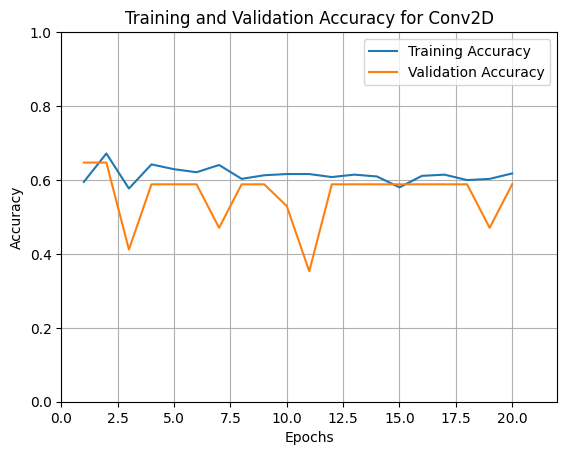

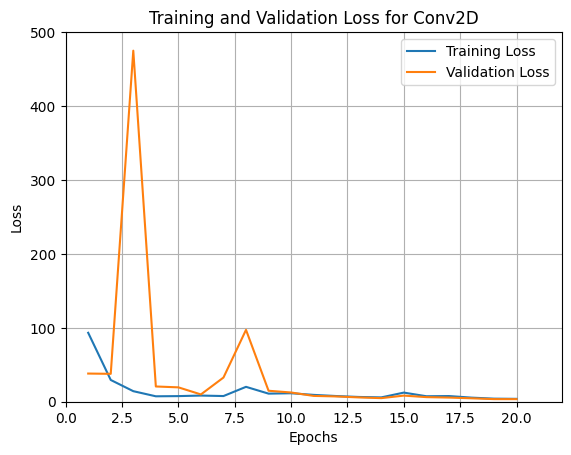

In [ ]:
train_accuracy_CNN = CNN_model_history.history['accuracy']
val_accuracy_CNN = CNN_model_history.history['val_accuracy']
loss_CNN = CNN_model_history.history['loss']
val_loss_CNN = CNN_model_history.history['val_loss']

epochs = range(1, len(train_accuracy_CNN) + 1)

x_range = [0, 22]
y_range = [0, 1]
plt.xlim(x_range)
plt.ylim(y_range)
plt.plot(epochs, train_accuracy_CNN, label='Training Accuracy')
plt.plot(epochs, val_accuracy_CNN, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Conv2D')
plt.legend()
plt.grid(True)
plt.show()

x_range = [0, 22]
y_range = [0, 500]
plt.xlim(x_range)
plt.ylim(y_range)
plt.plot(epochs, loss_CNN, label='Training Loss')
plt.plot(epochs, val_loss_CNN, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Conv2D')
plt.legend()
plt.grid(True)
plt.show()

# Implementing ResNet50

In [ ]:
resnet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(480, 640, 3))

resnet50_base_model.trainable = False

resnet50_model = Sequential([
    resnet50_base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # for binary classification
])

resnet50_model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

resnet50_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 15, 20, 2048)      23587712  
                                                                 
 flatten_5 (Flatten)         (None, 614400)            0         
                                                                 
 dense_10 (Dense)            (None, 256)               157286656 
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 180874625 (689.98 MB)
Trainable params: 157286913 (600.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
history_resnet50 = resnet50_model.fit(
    X_train, y_train,
    epochs=10,  # adjust the number of epochs as needed
    batch_size=2,  # adjust the batch size as needed
    validation_data=(X_test, y_test)
)


Epoch 1/10
374/374 [==============================] - 27s 61ms/step - loss: 63.4012 - accuracy: 0.5334 - val_loss: 0.6874 - val_accuracy: 0.5882
Epoch 2/10
374/374 [==============================] - 21s 56ms/step - loss: 1.6489 - accuracy: 0.5856 - val_loss: 0.6792 - val_accuracy: 0.5882
Epoch 3/10
374/374 [==============================] - 21s 56ms/step - loss: 0.6788 - accuracy: 0.5882 - val_loss: 0.6776 - val_accuracy: 0.5882
Epoch 4/10
374/374 [==============================] - 21s 56ms/step - loss: 0.6782 - accuracy: 0.5882 - val_loss: 0.6775 - val_accuracy: 0.5882
Epoch 5/10
374/374 [==============================] - 21s 56ms/step - loss: 0.6780 - accuracy: 0.5882 - val_loss: 0.6775 - val_accuracy: 0.5882
Epoch 6/10
374/374 [==============================] - 21s 56ms/step - loss: 0.6780 - accuracy: 0.5882 - val_loss: 0.6778 - val_accuracy: 0.5882
Epoch 7/10
374/374 [==============================] - 21s 56ms/step - loss: 0.6782 - accuracy: 0.5882 - val_loss: 0.6776 - val_accuracy

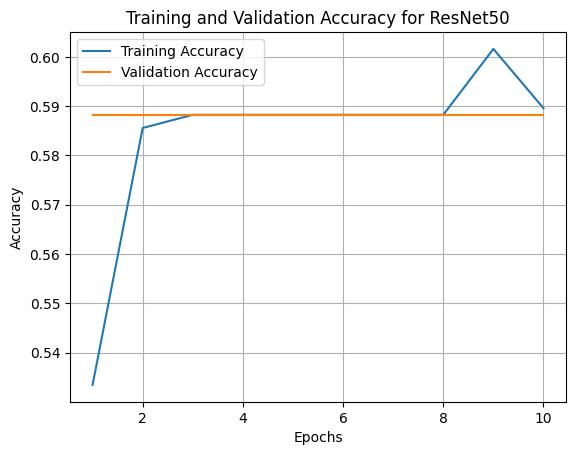

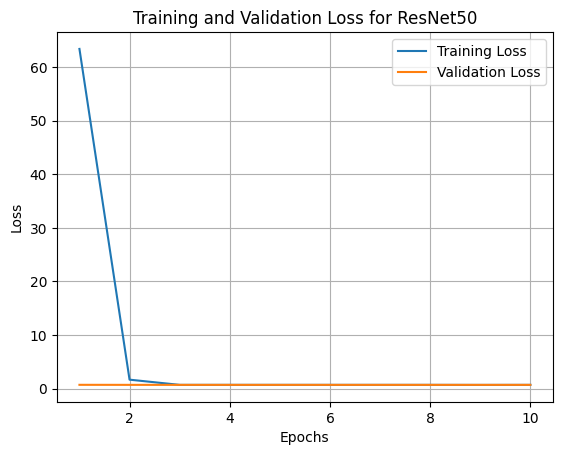

In [ ]:
train_accuracy_resnet50 = history_resnet50.history['accuracy']
val_accuracy_resnet50 = history_resnet50.history['val_accuracy']
loss_resnet50 = history_resnet50.history['loss']
val_loss_resnet50 = history_resnet50.history['val_loss']

epochs = range(1, len(train_accuracy_resnet50) + 1)

plt.plot(epochs, train_accuracy_resnet50, label='Training Accuracy')
plt.plot(epochs, val_accuracy_resnet50, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ResNet50')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, loss_resnet50, label='Training Loss')
plt.plot(epochs, val_loss_resnet50, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for ResNet50')
plt.legend()
plt.grid(True)
plt.show()

# Implementing VGG16

In [ ]:
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(480, 640, 3))

vgg16_base_model.trainable = False

input_tensor = Input(shape=(480, 640, 3))

output_tensor = vgg16_base_model(input_tensor)

flatten_layer = Flatten()(output_tensor)

dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.002))(flatten_layer)
output_layer = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.003))(dense1)

vgg16_model = Model(inputs=input_tensor, outputs=output_layer)

vgg16_model.compile(optimizer=Adam(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])

vgg16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 15, 20, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 153600)            0         
                                                                 
 dense (Dense)               (None, 256)               39321856  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 54036801 (206.13 MB)
Trainable params: 39322113 (150.00 MB)
Non-trainable params: 14714688 (56.13 MB)
____________

In [ ]:
history_vgg16 = vgg16_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=4,
    validation_data=(X_test, y_test)
)

Epoch 1/10
187/187 [==============================] - 23s 89ms/step - loss: 5.5846 - accuracy: 0.8088 - val_loss: 3.5840 - val_accuracy: 0.7647
Epoch 2/10
187/187 [==============================] - 15s 82ms/step - loss: 2.5926 - accuracy: 0.8904 - val_loss: 5.2284 - val_accuracy: 0.7647
Epoch 3/10
187/187 [==============================] - 15s 83ms/step - loss: 1.4106 - accuracy: 0.9452 - val_loss: 0.7103 - val_accuracy: 1.0000
Epoch 4/10
187/187 [==============================] - 16s 83ms/step - loss: 0.5753 - accuracy: 0.9786 - val_loss: 0.5053 - val_accuracy: 0.9412
Epoch 5/10
187/187 [==============================] - 16s 84ms/step - loss: 0.2804 - accuracy: 0.9973 - val_loss: 0.2648 - val_accuracy: 0.9412
Epoch 6/10
187/187 [==============================] - 16s 86ms/step - loss: 0.1399 - accuracy: 1.0000 - val_loss: 0.1424 - val_accuracy: 1.0000
Epoch 7/10
187/187 [==============================] - 16s 87ms/step - loss: 0.5534 - accuracy: 0.9385 - val_loss: 0.6988 - val_accuracy:

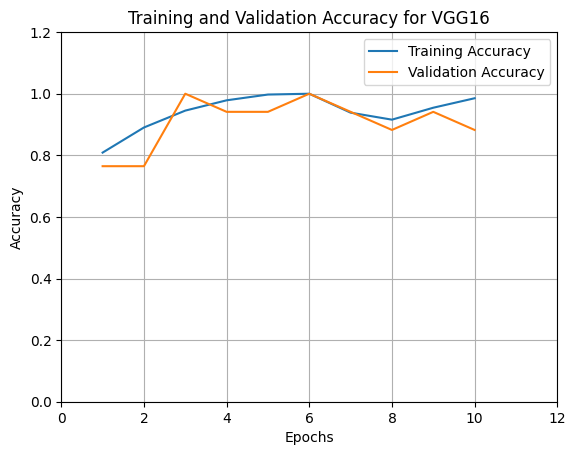

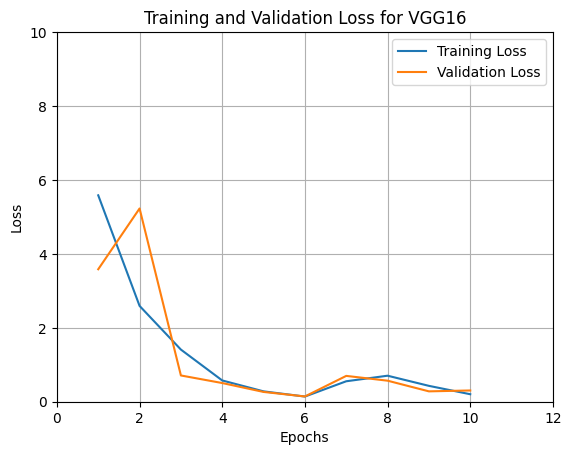

In [ ]:
train_accuracy_vgg16 = history_vgg16.history['accuracy']
val_accuracy_vgg16 = history_vgg16.history['val_accuracy']
loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']

epochs = range(1, len(train_accuracy_vgg16) + 1)

x_range = [0, 12]
y_range = [0, 1.2]
plt.xlim(x_range)
plt.ylim(y_range)
plt.plot(epochs, train_accuracy_vgg16, label='Training Accuracy')
plt.plot(epochs, val_accuracy_vgg16, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for VGG16')
plt.legend()
plt.grid(True)
plt.show()


x_range = [0, 12]
y_range = [0, 10]
plt.xlim(x_range)
plt.ylim(y_range)
plt.plot(epochs, loss_vgg16, label='Training Loss')
plt.plot(epochs, val_loss_vgg16, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VGG16')
plt.legend()
plt.grid(True)
plt.show()

#Fetching accuracies from latest epoch

In [ ]:
# Get the accuracy from the history object for the VGG16 model
train_accuracy_vgg16 = history_vgg16.history['accuracy']
val_accuracy_vgg16 = history_vgg16.history['val_accuracy']
print("VGG16 Model:")
print("Training Accuracy:", train_accuracy_vgg16[-1])  # Print the last epoch's training accuracy
print("Validation Accuracy:", val_accuracy_vgg16[-1])

VGG16 Model:
Training Accuracy: 0.9852941036224365
Validation Accuracy: 0.8823529481887817


#Predicting the trained model on test data

In [ ]:
predicted_labels = vgg16_model.predict(X_test)


1/1 [==============================] - 14s 14s/step


#Processing Predicted Labels to create Confusion matrix

In [ ]:
threshold = 0.5
binary_predictions = np.where(predicted_labels > threshold, 1, 0)
predicted_labels = np.ravel(binary_predictions)

#Confusion Matrix on the test data

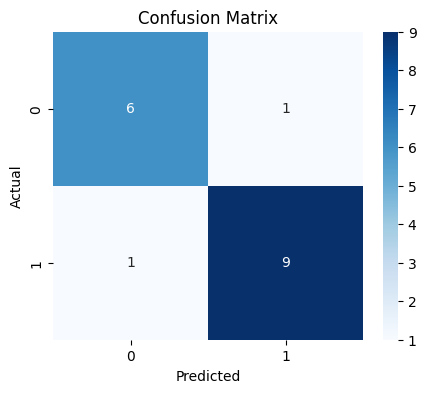

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, predicted_labels)


plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Metric values of the trained model

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted_labels, labels=[0, 1]).ravel()
print("Positive - Authentic, Negative - Counterfiet")
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)
print("True Positive:", tp)

Positive - Authentic, Negative - Counterfiet
True Negative: 6
False Positive: 1
False Negative: 1
True Positive: 9


In [ ]:
training_accuracy , validation_accuracy = [train_accuracy_vgg16[-1],val_accuracy_vgg16[-1]]
print("Final Training Accuracy of proposed model:", str(round(training_accuracy*100,3))+"%")
print("Final Validation Accuracy of proposed model:", str(round(validation_accuracy*100,3))+"%")

Final Training Accuracy of proposed model: 98.529%
Final Validation Accuracy of proposed model: 88.235%


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.90      0.90      0.90        10

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17



#Sample Code to save the model and load and run it on any dataset

In [ ]:

vgg16_model.save("/content/drive/MyDrive/final_vgg_model.h5")

model = tf.keras.models.load_model('/content/drive/MyDrive/final_vgg_model.h5')
vgg16_test_loss, vgg16_test_accuracy = model.evaluate(resized_image_data, target_data)
print("VGG16 Test Accuracy:", vgg16_test_accuracy)

3/3 [==============================] - 43s 9s/step - loss: 0.1780 - accuracy: 0.9765
VGG16 Test Accuracy: 0.9764705896377563
